# Preparation

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss
from sklearn.metrics import confusion_matrix, classification_report

# Data

In [ ]:
BASE_DIR = "/content/drive/My Drive/SM-Thesis/"

data = pd.read_csv(BASE_DIR + 'dataset/all users.csv',
               usecols=['screen_name', 'statuses_count', 'followers_count', 'friends_count', 'favorites_count', 'listed_count', 'label'])

In [ ]:
# Class count
count_class_0, count_class_1 = data.label.value_counts()

# Divide by class
df_class_0 = data[data['label'] == 'genuine']
df_class_1 = data[data['label'] == 'bot']

df_class_1_over = df_class_1.sample(count_class_0, replace=True)
datares = pd.concat([df_class_0, df_class_1_over], axis=0)
datares = datares.sample(frac=1).reset_index(drop=True)

In [ ]:
random.seed(24)
X = datares.iloc[:,0:6].values
y = datares['label']
y = np.array([1 if i=='bot' else 0 for i in y])

Random over-sampling:
genuine    1344
bot        1344
Name: label, dtype: int64


Text(0.5, 1.0, 'Number of genuine and malicious accounts')

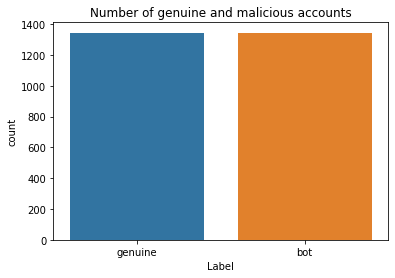

In [ ]:
print('Random over-sampling:')
print(datares.label.value_counts())

sns.countplot(datares['label'])
plt.xlabel('Label')
plt.title('Number of genuine and malicious accounts')

# Train with KFold 

In [ ]:
cols_score = ["Accuracy", "Precision", "Recall", "F1-Score", "ROC/AUC"]

In [ ]:
classifiers = [LogisticRegression(random_state=19),
               BernoulliNB(),
               AdaBoostClassifier(n_estimators=100, random_state=19),
               RandomForestClassifier(random_state=19),
               DecisionTreeClassifier(random_state=19),
               MLPClassifier(random_state=19)]

In [ ]:
def draw_confusionmatrix(y_test, y_pred, label):
    plt.figure(figsize=(5,4))
    
    cm = confusion_matrix(y_test, y_pred, labels=label)
    ax = plt.subplot()
    ax = sns.heatmap(cm, annot=True, fmt='g', cmap='Blues'); #annot=True to annotate cells

    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicted label');ax.set_ylabel('True label');  
    ax.xaxis.set_ticklabels(label); ax.yaxis.set_ticklabels(label);


In [ ]:
def train_kfold(clf, X, y):
  df_score = pd.DataFrame(columns=cols_score)
  df_pred = pd.DataFrame(columns=['pred'])
  df_true = pd.DataFrame(columns=['true'])
  # df_user = pd.DataFrame(columns=['user'])

  kf = KFold(n_splits=10, shuffle=True, random_state=1)

  i = 0
  j = 0
  for train_index, test_index in kf.split(X):
    X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
    # print("TRAIN: ", len(y_train), "TEST:", len(y_test))
    # users = datares['screen_name'][test_index]

    clf.fit(X_train[:], y_train)

    # print("="*30)
    # print(name)
    
    # print('****Result****')
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_pred)
    log = np.array([acc, prec, rec, f1, roc])
    # print("Accuracy: {:.4f}\nPrecision: {:.4f}\nRecall: {:.4f}\nF1 Score: {:.4f}\nROC/AUC Score: {:.4f}".format(acc, prec, rec, f1, roc))
    
    y_test = ['bot' if i==1 else 'genuine' for i in y_test]
    y_pred = ['bot' if i==1 else 'genuine' for i in y_pred]

    df_score.loc[i] = log
    df_pred.loc[:, j] = pd.Series(y_pred)
    df_true.loc[:, j] = pd.Series(y_test)
    # df_user.loc[:, j] = pd.Series(users)
    i=i+1
    j=j+1

    # label = ['genuine', 'bot']
    # print("="*30)
    # print(classification_report(y_test, pred, labels=label))
    # print("="*30)
    # print(draw_confusionmatrix(y_test, pred, label))
   
  return df_score, df_pred, df_true

In [ ]:
for i, clf in enumerate(classifiers):
  name = clf.__class__.__name__

  df_scores, df_preds, df_true, df_user = train_kfold(clf, X, y)
  df_scores.to_csv(BASE_DIR + 'Meta Features/score_' + name + '.csv')
  df_preds.to_csv(BASE_DIR + 'Meta Features/pred_' + name + '.csv')
df_true.to_csv(BASE_DIR + 'Meta Features/true.csv')


In [ ]:
df_scores

,user,0,1,2,3,4,5,6,7,8,9
4,NaN,kanalbali,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,OryzasativaFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,NaN,jalantikuscom,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,NaN,ilyasiregar,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40,NaN,Omachsin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2642,NaN,laksonotri3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2652,NaN,Bayu91Raditya,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2654,NaN,kebolara,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2679,NaN,rusy_df,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
